In [29]:
import sys
sys.path.append('../src')
import preprocessing
import data_augmentation_1D as data_aug
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

In [2]:
# Définir le chemin racine du dataset
dataset_root = "/mnt/c/Users/onerf/Documents/UMons/Master2/RHEA/src/db/"

# Charger les profils depuis les dossiers spécifiés dans le dataset
profiles  = preprocessing.sleepers_dataset_from_directory(dataset_root + "sleepers_db/")
profiles_test = preprocessing.sleepers_dataset_from_directory(dataset_root + "test/")


2024-03-05 15:12:23.615844: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 15:12:23.647917: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 15:12:23.647989: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 15:12:23.652194: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 15:12:23.652321: I external/local_xla/xla/stream_executor

In [78]:
x = profiles.data[0]
augmentations = {
        'original' :x ,
        'vertical flip': np.flip(x),
        'horizontal flip':  data_aug.rotate(pd.Series(x), 180), 
        'rotation': data_aug.rotate(pd.Series(x), 0.9, random=True), 
        'shift_y': data_aug.shift_data_y(pd.Series(x)), 
        'shift_x': data_aug.shift_data_x(pd.Series(x)), 
        'noise': data_aug.add_noise(pd.Series(x)), 
        'random': data_aug.random_augmentation(pd.Series(x))
}

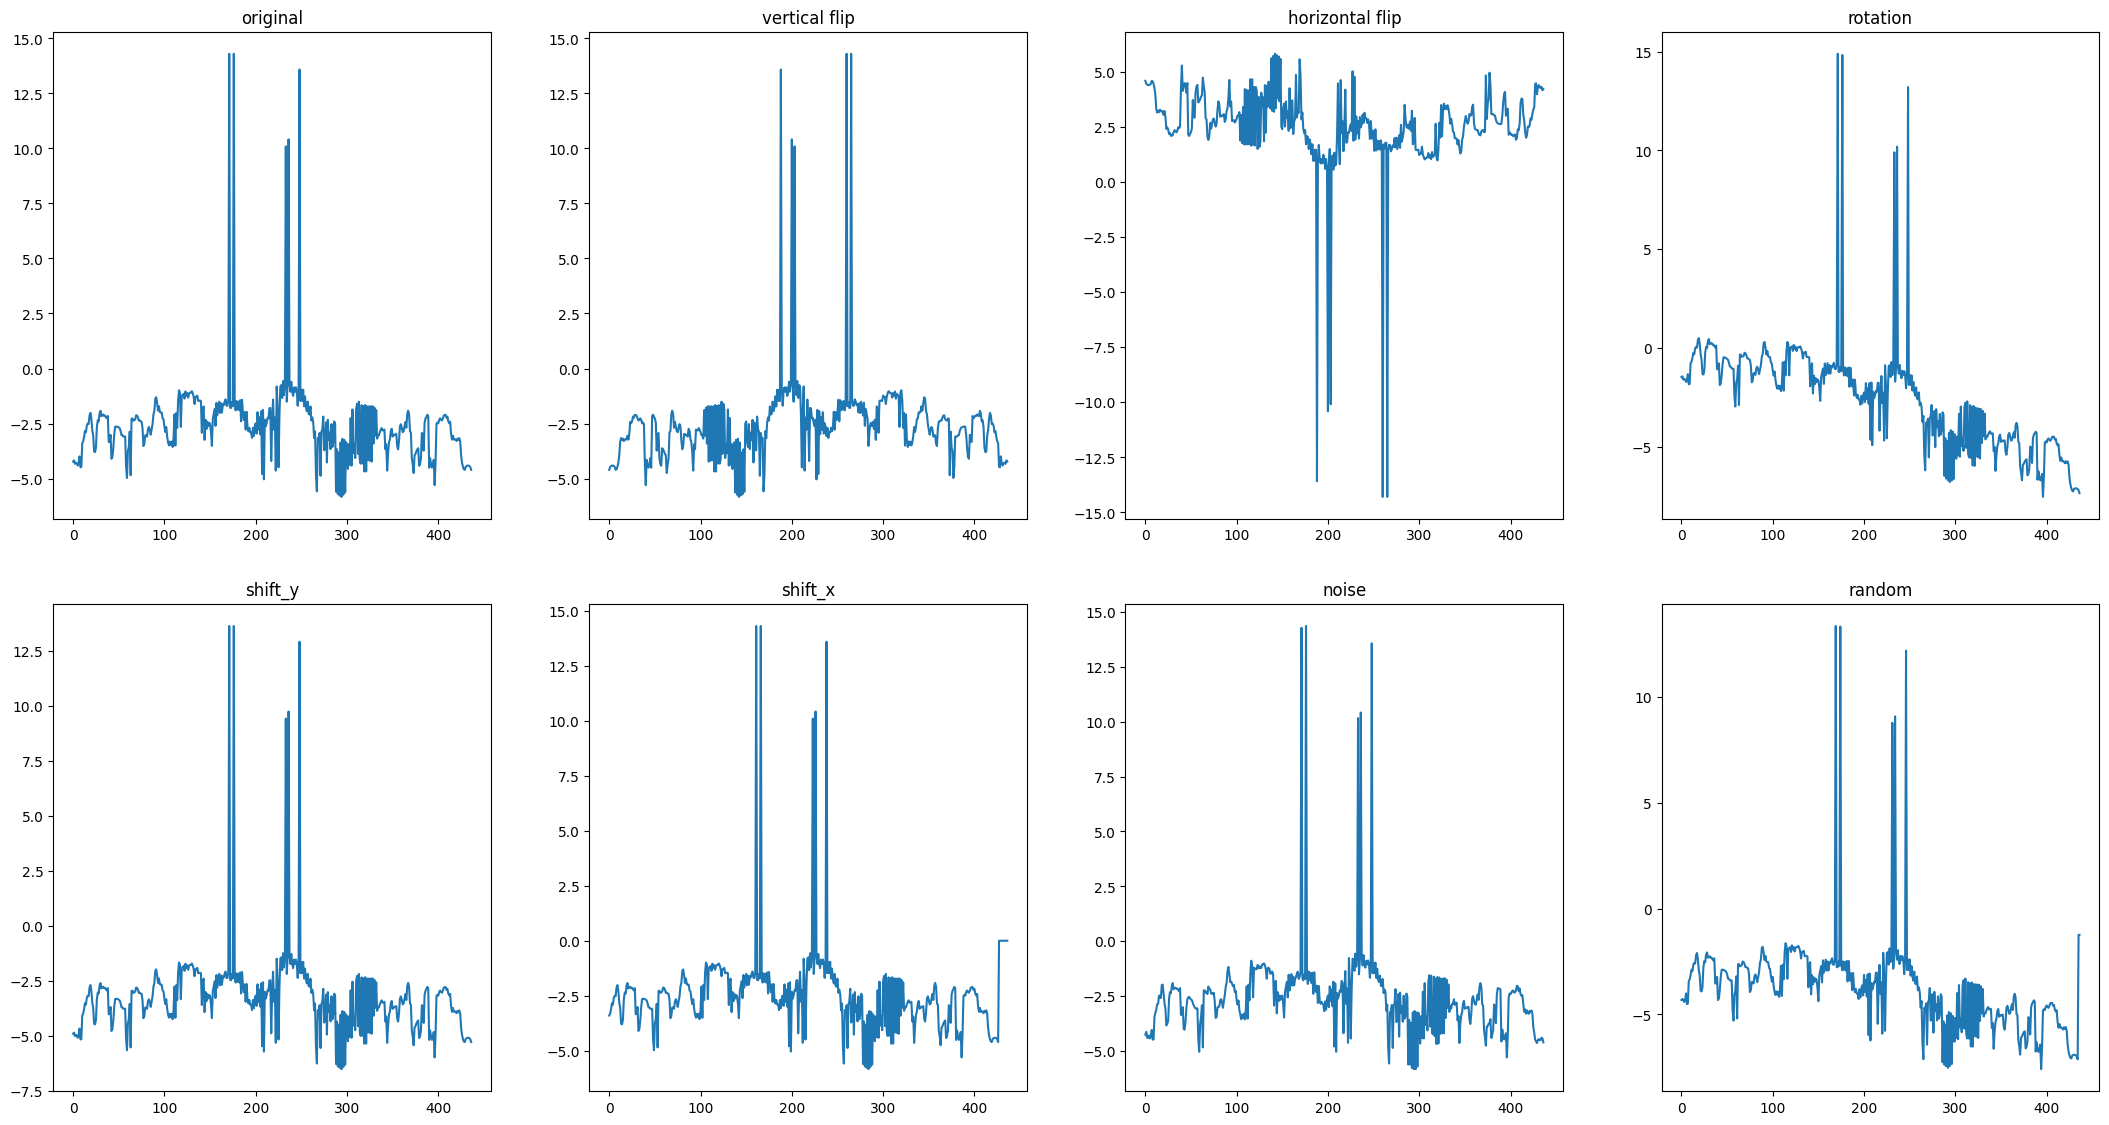

In [79]:
fig, axs = plt.subplots(2 , 4, figsize=(22,  1.5*len(augmentations) ))
fig.tight_layout(pad=4.0)

line_index = 0  # Indice pour gérer la position actuelle du sous-graphique

# Correction de la récupération de l'objet History depuis la liste
for col_index, augmentation_name in enumerate(augmentations.keys()):
    axs[line_index,col_index%4].plot(augmentations[augmentation_name])
    axs[line_index,col_index%4].set_title(augmentation_name)

    if col_index == 3 : 
        line_index += 1

plt.show()